In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.utils.stacked_dataloader import StackedDataBunch

In [4]:
from fastai.text import *

## MultitaskTransformer Training

Multitask Training is an extension of [MusicTransformer](../music_transformer/Train.ipynb).

Instead a basic language model that predicts the next word...

We train on multiple tasks
* [Next Word](../music_transformer/Train.ipynb)
* [Bert Mask](https://arxiv.org/abs/1810.04805)
* [Sequence to Sequence Translation](http://jalammar.github.io/illustrated-transformer/)

This gives a more generalized model and also let's you do some really cool [predictions](Generate.ipynb)

## End to end training pipeline 

1. Create and encode dataset
2. Initialize Transformer MOdel
3. Train
4. Predict

In [5]:
# Location of your midi files
midi_path = Path('data/midi/examples')
midi_path.mkdir(parents=True, exist_ok=True)

# Location to save dataset
data_path = Path('data/numpy')
data_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'musicitem_data_save.pkl'
s2s_data_save_name = 'multiitem_data_save.pkl'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [6]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

18

### 2a. Create NextWord/Mask Dataset

In [7]:
processors = [Midi2ItemProcessor()]
data = MusicDataBunch.from_files(midi_files, data_path, processors=processors, 
                                 encode_position=True, dl_tfms=mask_lm_tfm, 
                                 bptt=5, bs=2)
data.save(data_save_name)

In [8]:
xb, yb = data.one_batch(); xb

{'msk': {'x': tensor([[  4,   4,  54, 145,   8],
          [ 59, 145,   4, 145,   8]]), 'pos': tensor([[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]])}, 'lm': {'x': tensor([[145,  59, 145,  54, 145],
          [145,  59, 145,  54, 145]]), 'pos': tensor([[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]])}}

Key:
* 'msk' = masked input
* 'lm' = next word input
* 'pos' = timestepped postional encoding. This is in addition to relative positional encoding

Note: MultitaskTransformer trains on both the masked input ('msk') and next word input ('lm') at the same time.

The encoder is trained on the 'msk' data, while the decoder is trained on 'lm' data.



### 2b. Create sequence to sequence dataset

In [9]:
processors = [Midi2MultitrackProcessor()]
s2s_data = MusicDataBunch.from_files(midi_files, data_path, processors=processors, 
                                     preloader_cls=S2SPreloader, list_cls=S2SItemList,
                                     dl_tfms=melody_chord_tfm,
                                     bptt=5, bs=2)
s2s_data.save(s2s_data_save_name)

Structure

In [10]:
xb, yb = s2s_data.one_batch(); xb

{'c2m': {'enc': tensor([[  5,   1,  61, 145,  59],
          [  5,   1,  57, 153,  53]]), 'enc_pos': tensor([[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]]), 'dec': tensor([[  6,   1,  85, 143,   8],
          [  6,   1,  77, 139,   8]]), 'dec_pos': tensor([[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]])}, 'm2c': {'enc': tensor([[  6,   1,  85, 143,   8],
          [  6,   1,  77, 139,   8]]), 'enc_pos': tensor([[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]]), 'dec': tensor([[  5,   1,  61, 145,  59],
          [  5,   1,  57, 153,  53]]), 'dec_pos': tensor([[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]])}}

Key:
* 'c2m' = chord2melody translation
 * enc = chord
 * dec = melody
* 'm2c' = next word input
 * enc = melody
 * dec = chord
* 'pos' = timestepped postional encoding. Gives the model a better reference when translating

Note: MultitaskTransformer trains both translations ('m2c' and 'c2m') at the same time. 

## 3. Initialize Model

In [11]:
# Load Data
batch_size = 2
bptt = 128

lm_data = load_data(data_path, data_save_name, 
                    bs=batch_size, bptt=bptt, encode_position=True,
                    dl_tfms=mask_lm_tfm)

s2s_data = load_data(data_path, s2s_data_save_name, 
                     bs=batch_size//2, bptt=bptt,
                     preloader_cls=S2SPreloader, dl_tfms=melody_chord_tfm)

# Combine both dataloaders so we can train multiple tasks at the same time
data = StackedDataBunch([lm_data, s2s_data])

In [12]:
# Create Model
config = multitask_config(); config

learn = multitask_model_learner(data, config.copy())
# learn.to_fp16(dynamic=True) # Enable for mixed precision

In [13]:
learn.model

MultiTransformer(
  (encoder): MTEncoder(
    (embed): TransformerEmbedding(
      (embed): Embedding(312, 512, padding_idx=1)
      (pos_enc): PositionalEncoding()
      (beat_enc): Embedding(32, 512, padding_idx=0)
      (bar_enc): Embedding(1024, 512, padding_idx=0)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): MTEncoderBlock(
        (mha1): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=512, bias=True)
          (k_wgt): Linear(in_features=512, out_features=512, bias=True)
          (v_wgt): Linear(in_features=512, out_features=512, bias=True)
          (drop_att): Dropout(p=0.1, inplace=False)
          (drop_res): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=512, out_features=512, bias=True)
        )
        (mha2): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=

# 4. Train

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,7.452965,9.445184,0.000000,0.207831,0.007874,0.000000,00:06
1,7.096860,8.195106,0.264286,0.272549,0.330709,0.000000,00:06
2,7.023245,8.480180,0.247034,0.272549,0.330709,0.000000,00:06
3,6.770488,7.916190,0.306989,0.205882,0.330709,0.000000,00:06


In [15]:
learn.save('example')

## Predict

---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

In [16]:
# midi_files = get_files(midi_path, '.mid', recurse=True)
midi_file = Path('data/midi/notebook_examples/single_bar_example.mid'); midi_file

PosixPath('data/midi/notebook_examples/single_bar_example.mid')

Non midi note detected. Only returning valid portion. Index, seed 18 (28, 2)


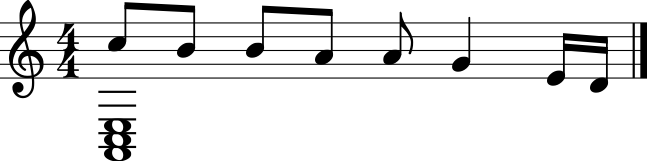

In [19]:
next_word = nw_predict_from_midi(learn, midi_file, n_words=20, seed_len=8); next_word.show()

Predicted past counter-part length. Returning early


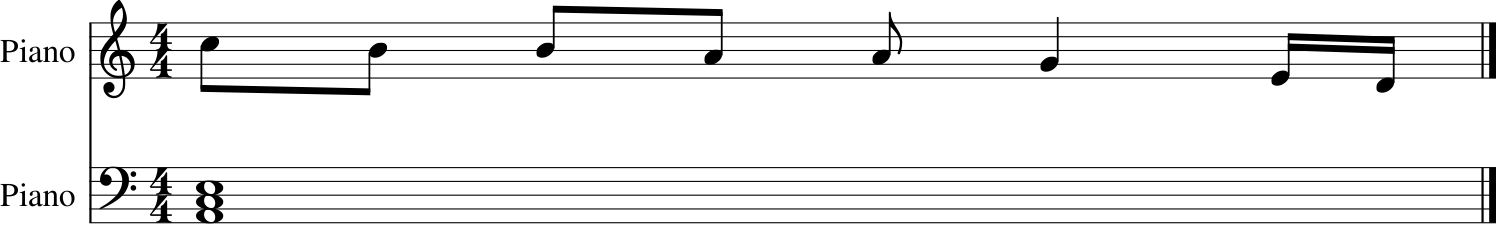

In [20]:
pred_melody = s2s_predict_from_midi(learn, midi_file, n_words=20, seed_len=4, pred_melody=True); pred_melody.show()

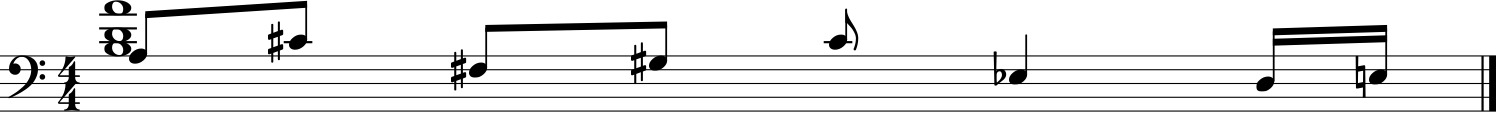

In [22]:
pred_notes = mask_predict_from_midi(learn, midi_file, predict_notes=True); pred_notes.show()